In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# ebayScraper.py
## Used for generating {category}.csv
### (API Keys have been removed)

```python

import requests
import time
import os
import re
from bs4 import BeautifulSoup

#
# View Item URL is used to scrape seller data
#

view_item = 'https://api.ebay.com/buy/browse/v1/item/v1|{ITEM NUMBER HERE}|0'

#
# Completed Items is API URL for finding completed items... Update Category ID # for category you want to scrape
#

completed_items = 'http://svcs.ebay.com/services/search/FindingService/v1?OPERATION-NAME=findCompletedItems&SECURITY-APPNAME=APIKEY&RESPONSE-DATA-FORMAT=JSON&REST-PAYLOAD&keywords=&categoryId={INPUT CATEGORY ID HERE}&itemFilter(0).name=ListingType&itemFilter(0).value=FixedPrice&paginationInput.entriesPerPage=100&paginationInput.pageNumber=1&sortOrder=StartTimeNewest'

#
# Authorization Token is constantly updating
#

headers = {'Authorization':'API KEY'}

r = requests.get(completed_items)
data = r.json()
number_of_pages = data['findCompletedItemsResponse'][0]['paginationOutput'][0]['totalPages'][0]
print('Number of Pages: '+number_of_pages)

with open('dataframe.csv','w') as dataframe:
        dataframe.write('item_number, item_title, payment_method, postal_code, shipping_method, sales_price, selling_state, best_offer, bin_available, start_time, end_time, listing_type, returns_accepted, condition, top_rated, seller, feedback_percentage, feedback_score, description\n')

count = 0

#
# Rename CSV for {category}.csv
#

with open('dataframe.csv','a') as dataframe:
    for i in range (1,int(number_of_pages)):
        completed_items = 'http://svcs.ebay.com/services/search/FindingService/v1?OPERATION-NAME=findCompletedItems&SECURITY-APPNAME=APIKEY&RESPONSE-DATA-FORMAT=JSON&REST-PAYLOAD&keywords=&categoryId=%2011450&itemFilter(0).name=ListingType&itemFilter(0).value=FixedPrice&paginationInput.entriesPerPage=100&paginationInput.pageNumber='+str(i)+'&sortOrder=StartTimeNewest'
        r = requests.get(completed_items, headers=headers)
        data = r.json()

        for j in range (0,100):
            item_number = data['findCompletedItemsResponse'][0]['searchResult'][0]['item'][j]['itemId'][0]
            item_title = str(data['findCompletedItemsResponse'][0]['searchResult'][0]['item'][j]['title'][0]).replace(",", "")
            item_title = item_title.replace('"', "")
            item_title = item_title.replace("'", "")
            try:
                payment_method = data['findCompletedItemsResponse'][0]['searchResult'][0]['item'][j]['paymentMethod'][0]
            except:
                payment_method = 'NA'
            try:
                postal_code = data['findCompletedItemsResponse'][0]['searchResult'][0]['item'][j]['postalCode'][0]
            except:
                postal_code = '00000'
            # location = data['findCompletedItemsResponse'][0]['searchResult'][0]['item'][j]['location'][0]
            shipping_method = data['findCompletedItemsResponse'][0]['searchResult'][0]['item'][j]['shippingInfo'][0]['shippingType'][0]
            sales_price = data['findCompletedItemsResponse'][0]['searchResult'][0]['item'][j]['sellingStatus'][0]['convertedCurrentPrice'][0]['__value__']
            selling_state = data['findCompletedItemsResponse'][0]['searchResult'][0]['item'][j]['sellingStatus'][0]['sellingState'][0]
            best_offer = data['findCompletedItemsResponse'][0]['searchResult'][0]['item'][j]['listingInfo'][0]['bestOfferEnabled'][0]
            bin_available = data['findCompletedItemsResponse'][0]['searchResult'][0]['item'][j]['listingInfo'][0]['buyItNowAvailable'][0]
            start_time = data['findCompletedItemsResponse'][0]['searchResult'][0]['item'][j]['listingInfo'][0]['startTime'][0]
            end_time = data['findCompletedItemsResponse'][0]['searchResult'][0]['item'][j]['listingInfo'][0]['endTime'][0]
            listing_type = data['findCompletedItemsResponse'][0]['searchResult'][0]['item'][j]['listingInfo'][0]['listingType'][0]
            returns_accepted = data['findCompletedItemsResponse'][0]['searchResult'][0]['item'][j]['returnsAccepted'][0]
            try:
                condition = data['findCompletedItemsResponse'][0]['searchResult'][0]['item'][j]['condition'][0]['conditionId'][0]
            except:
                condition = 'NA'
            top_rated = data['findCompletedItemsResponse'][0]['searchResult'][0]['item'][j]['topRatedListing'][0]

            print(item_number)
            count += 1
            print('\033c')
            print(str(count) +" items | pages:  "+ str(i))

            view_item = 'https://www.ebay.com/itm/'+str(item_number)+'?_trksid=p2349526.m4383.l10137.c10&nordt=true&rt=nc&orig_cvip=true0'
            try:
                r = requests.get(view_item)
                soup = BeautifulSoup(r.text, 'html.parser')

                seller = soup.find(class_='mbg-nw').text

                feedback_percentage = soup.find(id='si-fb')
                feedback_percentage = re.sub("[^0-9.]", "", str(feedback_percentage))

                feedback_score = soup.find(class_='mbg-l')
                feedback_score = re.sub("[^0-9]", "", str(feedback_score.text))

                #
                # View Description is URL for scraping item description, only len() is used
                #

                view_description = 'https://vi.vipr.ebaydesc.com/ws/eBayISAPI.dll?ViewItemDescV4&item='+str(item_number)
                r = requests.get(view_description)
                soup = BeautifulSoup(r.text, 'html.parser')

                print(view_description)

                description = soup.find(id='ds_div')
                description = len(description.text)

            except:
                print('excepted')
                time.sleep(1)
                seller = 'NA'
                feedback_percentage = 'NA'
                feedback_score = 'NA'
                description = 'NA'

            line = [item_number, item_title, payment_method, postal_code, shipping_method, sales_price, selling_state, best_offer, bin_available, start_time, end_time, listing_type, returns_accepted, condition, top_rated, seller, feedback_percentage, feedback_score, str(description)+'\n']
            dataframe.write(','.join(str(v) for v in line))
```

# Feedback.ipynb
## Used for scraping seller reviews from the sellers in {category}.csv

```python
import pandas as pd
import numpy as np
import itertools as it
from requests import get
from bs4 import BeautifulSoup as bs4
from time import sleep, time
from random import randint

startTime = time()

csvs = ['books', 'clothing', 'collectables', 'healthbeauty', 'homegarden', 'iphones', 'music', 'sporting']
users = []
for csv in csvs:
    csv = pd.read_csv(csv + '.csv')

    users = []
    for index in csv.index:
        users.append(csv.loc[index][' seller'])
    users = list(dict.fromkeys(users))
users.pop(0)

feedback_lists = []
ratings_lists = []
feedback_descriptions = []
user_fault = []
for user in users:
    #sleep(randint(1,3))
    print(user, "Elapsed Time: ", time()-startTime)
    request = get('https://feedback.ebay.com/ws/eBayISAPI.dll?ViewFeedback2&userid=' + str(user))
    page_html = bs4(request.text, 'html.parser')
    
    try:
        feedback_table=page_html.find('div', class_='CentralArea').find('table', {'id':'recentFeedbackRatingsTable'})
        
    except:
        print("Top Seller")
        user_fault.append(user)
        continue
    try:
        rows = feedback_table.find_all('tr', class_='fbsSmallYukon')
    except:
        print("Top Seller")
        user_fault.append(user)
        continue

    feedback_row = []
    for row in rows:
        feedback = row.find_all('td', {'id':'RFRId'})
        feedback_row.append(feedback)

    positive = []
    neutral = []
    negative = []
    count = 0
    while count < 3:
        one_month = ''
        six_month = ''
        twelve_month = ''

        try:
            one_month = feedback_row[count][0].a.text
        except:
            # It's a span instead of a and just ends up outputting 0 basically means no feedback
            one_month = '0'

        try:
            six_month = feedback_row[count][1].a.text
        except:
            six_month = '0'

        try:
            twelve_month = feedback_row[count][2].a.text
        except:
            twelve_month = '0'

        if count == 0:
            positive.append(one_month)
            positive.append(six_month)
            positive.append(twelve_month)
        elif count == 1:
            neutral.append(one_month)
            neutral.append(six_month)
            neutral.append(twelve_month)
        elif count == 2:
            negative.append(one_month)
            negative.append(six_month)
            negative.append(twelve_month)

        count = count + 1

    feedback_list = positive + neutral + negative
    feedback_lists.append(feedback_list)
    
    detailed_table = page_html.find('div', class_='CentralArea').find('div', class_='dsrRatingContent')
    try:
        rows = detailed_table.find_all('tr', class_='dsrRatingContentPadding')
        row_criterias = []
        row_ratings = []
        row_number_of_ratings = []
        for i in range(len(rows)):
            row_details = rows[i].find_all('td')
            row_criterias.append(row_details[0].text)
            row_ratings.append(row_details[1]['title'])
            row_number_of_ratings.append(row_details[2].text)
            #print(row_criteria, row_rating, row_number_of_ratings)

        ratings_list = [item for pair in zip(row_ratings, row_number_of_ratings + [0]) for item in pair]
        ratings_lists.append(ratings_list)
    except:
        l = [None] * 8
        ratings_lists.append(l)
    
    feedback_table_detail = page_html.find('table', class_='FbOuterYukon')
    try:
        seller_feedback = feedback_table_detail.find_all('tr', class_='')
    except:
        l = ['Private Feedback'] * 5
        feedback_descriptions.append(l)
        continue

    feedback_description = []
    count = 0
    while count < 5:
        try:
            feedback_description.append(seller_feedback[count].find_all('td')[1].text)
        except:
            feedback_description.append('N/A')
        count += 1
    feedback_descriptions.append(feedback_description)
```

## Read each individual category's CSV into its own pandas dataframe

In [2]:
iphones = pd.read_csv('iphones.csv')
androids = pd.read_csv('android.csv')
applelaptops = pd.read_csv('applelaptops.csv')
pclaptops = pd.read_csv('pclaptops.csv')
books = pd.read_csv('books.csv')
clothing = pd.read_csv('clothing.csv')
collectables = pd.read_csv('collectables.csv')
healthbeauty = pd.read_csv('healthbeauty.csv')
homegarden = pd.read_csv('homegarden.csv')
music = pd.read_csv('music.csv')
sporting = pd.read_csv('sporting.csv')

# Test Columns
iphones.columns

Index(['item_number', ' item_title', ' payment_method', ' postal_code',
       ' shipping_method', ' sales_price', ' selling_state', ' best_offer',
       ' bin_available', ' start_time', ' end_time', ' listing_type',
       ' returns_accepted', ' condition', ' top_rated', ' seller',
       ' feedback_percentage', ' feedback_score', ' description'],
      dtype='object')

In [3]:
dataframes = [
    iphones,
    androids,
    applelaptops,
    pclaptops,
    books,
    clothing,
    collectables,
    healthbeauty,
    homegarden,
    music,
    sporting
]

0      0 days 00:04:25
1      0 days 00:05:15
2      0 days 00:12:48
3      0 days 00:00:34
4      0 days 00:36:15
             ...      
9995   3 days 16:26:01
9996   3 days 16:26:06
9997   3 days 16:26:10
9998   3 days 16:26:17
9999   3 days 18:36:43
Name: time_to_sell, Length: 10000, dtype: timedelta64[ns]

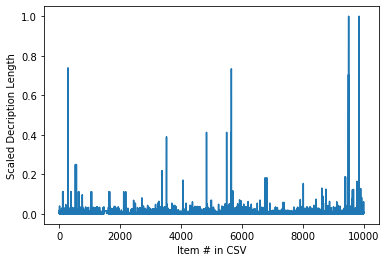

In [4]:
scaler = MinMaxScaler()


for df in dataframes:
    df[' description'] = scaler.fit_transform(df[[' description']])
    df[' start_time'] = pd.to_datetime(df[' start_time'])
    df[' end_time'] = pd.to_datetime(df[' end_time'])
    df['time_to_sell'] =  df[' end_time'] - df[' start_time']
    
# Test to see scaler applied
collectables[' description']
plt.ylabel("Scaled Decription Length")
plt.xlabel("Item # in CSV")
plt.plot(collectables[' description'])

# Test that time to sell is correctly calculated with pd.to_datetime
music['time_to_sell']

In [5]:
test = iphones[(iphones[' feedback_score']) < 1 &
        (iphones[' description'] < 0.002) &
        (pd.isnull(iphones[' feedback_percentage']) == True)]

test[' start_time'] = pd.to_datetime(test[' start_time'])
test[' end_time'] = pd.to_datetime(test[' end_time'])
test['Diff'] =  test[' end_time'] - test[' start_time']
# test[[' start_time', ' end_time', 'Diff']]
iphones['time_to_sell'].mean()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/s

Timedelta('1 days 20:35:17.641715')

# Preliminary Filtering
## (0 Feedback, Description Length < .002 on MinMax scale, Feedback % = Null)

In [6]:
iphone_scams = iphones[(iphones[' feedback_score']) < 1 &
        (iphones[' description'] < 0.002) &
        (pd.isnull(iphones[' feedback_percentage']) == True)]

android_scams = androids[(androids[' feedback_score']) < 1 &
        (androids[' description'] < 0.002) &
        (pd.isnull(androids[' feedback_percentage']) == True)]

applelaptop_scams = applelaptops[(applelaptops[' feedback_score']) < 1 &
        (applelaptops[' description'] < 0.002) &
        (pd.isnull(applelaptops[' feedback_percentage']) == True)]

pclaptop_scams = pclaptops[(pclaptops[' feedback_score']) < 1 &
        (pclaptops[' description'] < 0.002) &
        (pd.isnull(pclaptops[' feedback_percentage']) == True)]

books_scams = books[(books[' feedback_score']) < 1 &
        (books[' description'] < 0.002) &
        (pd.isnull(books[' feedback_percentage']) == True)]

clothing_scams = clothing[(clothing[' feedback_score']) < 1 &
        (clothing[' description'] < 0.002) &
        (pd.isnull(clothing[' feedback_percentage']) == True)]

collectables_scams = collectables[(collectables[' feedback_score']) < 1 &
        (collectables[' description'] < 0.002) &
        (pd.isnull(collectables[' feedback_percentage']) == True)]

healthbeauty_scams = healthbeauty[(healthbeauty[' feedback_score']) < 1 &
        (healthbeauty[' description'] < 0.002) &
        (pd.isnull(healthbeauty[' feedback_percentage']) == True)]

homegarden_scams = homegarden[(homegarden[' feedback_score']) < 1 &
        (homegarden[' description'] < 0.002) &
        (pd.isnull(homegarden[' feedback_percentage']) == True)]

music_scams = music[(music[' feedback_score']) < 1 &
        (music[' description'] < 0.002) &
        (pd.isnull(music[' feedback_percentage']) == True)]

sporting_scams = sporting[(sporting[' feedback_score']) < 1 &
        (sporting[' description'] < 0.002) &
        (pd.isnull(sporting[' feedback_percentage']) == True)]

In [7]:
iphone_scamrate = len(iphone_scams) / len(iphones)
android_scamrate = len(android_scams) / len(androids)
applelaptop_scamrate = len(applelaptop_scams) / len(applelaptops)
pclaptop_scamrate = len(pclaptop_scams) / len(pclaptops)
book_scamrate = len(books_scams) / len(books)
clothing_scamrate = len(clothing_scams) / len(clothing)
collectable_scamrate = len(collectables_scams) / len(collectables)
healthbeauty_scamrate = len(healthbeauty_scams) / len(healthbeauty)
homegarden_scamrate = len(homegarden_scams) / len(homegarden)
music_scamrate = len(music_scams) / len(music)
sporting_scamrate = len(sporting_scams) / len(sporting)

scamrate_list = [
    iphone_scamrate,
    applelaptop_scamrate,
    pclaptop_scamrate,
    book_scamrate,
    clothing_scamrate,
    collectable_scamrate,
    healthbeauty_scamrate,
    homegarden_scamrate,
    music_scamrate,
    sporting_scamrate,
]

scamrate_list = list(map(lambda x: x * 100, scamrate_list))

In [8]:
print(scamrate_list)

[3.3115755434457155, 1.9, 1.5142857142857145, 0.30120481927710846, 1.6199999999999999, 0.97009700970097, 1.66, 1.52, 0.13, 0.6]


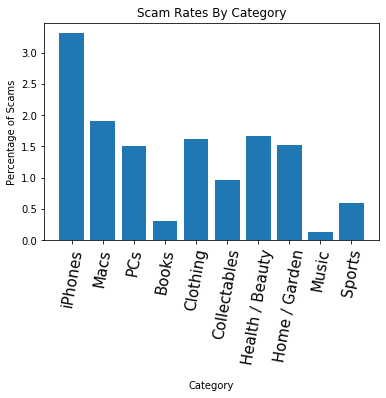

In [9]:
catname_list = [
    'iPhones',
    'Macs',
    'PCs',
    'Books',
    'Clothing',
    'Collectables',
    'Health / Beauty',
    'Home / Garden',
    'Music',
    'Sports',
]
index = np.arange(len(catname_list))
plt.bar(index, scamrate_list)
plt.xticks(index, catname_list, fontsize=15, rotation=80)
plt.ylabel("Percentage of Scams")
plt.xlabel("\nCategory")
plt.title('Scam Rates By Category')
plt.show()

## How big is the subset of scams with seller name matching [a-z]_# ?

In [10]:
reg_iphone = len(iphone_scams[iphone_scams[' seller'].str.contains('[a-z]+_+[\d]', regex=True)]) / len(iphone_scams) * 100
reg_applelaptop = len(applelaptop_scams[applelaptop_scams[' seller'].str.contains('[a-z]+_+[\d]', regex=True)]) / len(applelaptop_scams) * 100
reg_pclaptop = len(pclaptop_scams[pclaptop_scams[' seller'].str.contains('[a-z]+_+[\d]', regex=True)]) / len(pclaptop_scams) * 100
reg_book = len(books_scams[books_scams[' seller'].str.contains('[a-z]+_+[\d]', regex=True)]) / len(books_scams) * 100
reg_clothing = len(clothing_scams[clothing_scams[' seller'].str.contains('[a-z]+_+[\d]', regex=True)]) / len(clothing_scams) * 100
reg_collectables = len(collectables_scams[collectables_scams[' seller'].str.contains('[a-z]+_+[\d]', regex=True)]) / len(collectables_scams) * 100
reg_healthbeauty = len(healthbeauty_scams[healthbeauty_scams[' seller'].str.contains('[a-z]+_+[\d]', regex=True)]) / len(healthbeauty_scams) * 100
reg_homegarden = len(homegarden_scams[homegarden_scams[' seller'].str.contains('[a-z]+_+[\d]', regex=True)]) / len(homegarden_scams) * 100
reg_music = len(music_scams[music_scams[' seller'].str.contains('[a-z]+_+[\d]', regex=True)]) / len(music_scams) * 100
reg_sporting = len(sporting_scams[sporting_scams[' seller'].str.contains('[a-z]+_+[\d]', regex=True)]) / len(sporting_scams) * 100

regname_list = [
    reg_iphone,
    reg_applelaptop,
    reg_pclaptop,
    reg_book,
    reg_clothing,
    reg_collectables,
    reg_healthbeauty,
    reg_homegarden,
    reg_music,
    reg_sporting,
]

print(regname_list)

[17.90235081374322, 29.736842105263158, 30.18867924528302, 10.0, 29.01234567901235, 14.432989690721648, 25.903614457831324, 30.92105263157895, 30.76923076923077, 38.333333333333336]


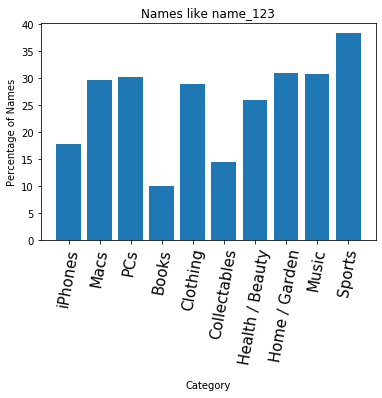

In [11]:
catname_list = [
    'iPhones',
    'Macs',
    'PCs',
    'Books',
    'Clothing',
    'Collectables',
    'Health / Beauty',
    'Home / Garden',
    'Music',
    'Sports',
]
index = np.arange(len(catname_list))
plt.bar(index, regname_list)
plt.xticks(index, catname_list, fontsize=15, rotation=80)
plt.ylabel("Percentage of Names")
plt.xlabel("\nCategory")
plt.title('Names like name_123')
plt.show()

In [12]:
iphone_tts = iphones['time_to_sell'].mean()
applelaptop_tts = applelaptops['time_to_sell'].mean()
pclaptop_tts = pclaptops['time_to_sell'].mean()
book_tts = books['time_to_sell'].mean()
clothing_tts = clothing['time_to_sell'].mean()
collectable_tts = collectables['time_to_sell'].mean()
healthbeauty_tts = healthbeauty['time_to_sell'].mean()
homegarden_tts = homegarden['time_to_sell'].mean()
music_tts = music['time_to_sell'].mean()
sporting_tts = sporting['time_to_sell'].mean()

tts_list = [
    iphone_tts,
    applelaptop_tts,
    pclaptop_tts,
    book_tts,
    clothing_tts,
    collectable_tts,
    healthbeauty_tts,
    homegarden_tts,
    music_tts,
    sporting_tts,
]

tts_list

[Timedelta('1 days 20:35:17.641715'),
 Timedelta('3 days 16:59:30.916550'),
 Timedelta('0 days 21:05:58.888000'),
 Timedelta('1 days 00:10:01.058534'),
 Timedelta('0 days 00:49:50.149600'),
 Timedelta('0 days 09:09:20.019501'),
 Timedelta('0 days 12:30:05.909000'),
 Timedelta('0 days 07:17:00.824100'),
 Timedelta('0 days 22:28:04.634800'),
 Timedelta('0 days 05:08:54.786900')]

In [13]:
iphonescam_tts = iphone_scams['time_to_sell'].mean()
applelaptopscam_tts = applelaptop_scams['time_to_sell'].mean()
pclaptopscam_tts = pclaptop_scams['time_to_sell'].mean()
bookscam_tts = books_scams['time_to_sell'].mean()
clothingscam_tts = clothing_scams['time_to_sell'].mean()
collectablescam_tts = collectables_scams['time_to_sell'].mean()
healthbeautyscam_tts = healthbeauty_scams['time_to_sell'].mean()
homegardenscam_tts = homegarden_scams['time_to_sell'].mean()
musicscam_tts = music_scams['time_to_sell'].mean()
sportingscam_tts = sporting_scams['time_to_sell'].mean()

scamtts_list = [
    iphonescam_tts,
    applelaptopscam_tts,
    pclaptopscam_tts,
    bookscam_tts,
    clothingscam_tts,
    collectablescam_tts,
    healthbeautyscam_tts,
    homegardenscam_tts,
    musicscam_tts,
    sportingscam_tts,
]

scamtts_list

[Timedelta('0 days 08:44:25.663652'),
 Timedelta('1 days 02:01:10.431578'),
 Timedelta('0 days 10:59:58.735849'),
 Timedelta('0 days 02:18:35.766666'),
 Timedelta('0 days 00:26:14.098765'),
 Timedelta('0 days 02:08:25.092783'),
 Timedelta('0 days 12:21:28.174698'),
 Timedelta('0 days 08:59:21.578947'),
 Timedelta('0 days 11:50:45.076923'),
 Timedelta('0 days 03:59:23.416666')]

In [14]:
for a,b in zip(scamtts_list, tts_list):
    print(a.total_seconds() / b.total_seconds())
    
tts_list = [ x.total_seconds() for x in tts_list ]
scamtts_list = [ x.total_seconds() for x in scamtts_list ]


0.19602620195888096
0.2923811954832296
0.5213180036160613
0.09558236194796643
0.5264280975881608
0.23377088059820916
0.9884963038696764
1.2341938157225196
0.527233349430614
0.774943717678567


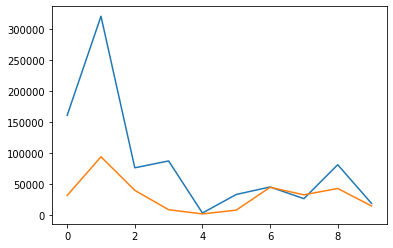

In [15]:
plt.plot(tts_list)
plt.plot(scamtts_list)